# Creating COCO dataset from labelme annotations

In [46]:
import os
import json
import labelme2coco
import shutil
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO

In [26]:
# first set up directories 
dataset_path = os.path.join(os.getcwd(), 'dataset')
coco_path = os.path.join(os.getcwd(), 'COCO_dataset')

ann_path = os.path.join(coco_path, "annotations")
img_path = os.path.join(coco_path, "images")

In [27]:
if not os.path.exists(coco_path):   
    os.mkdir(coco_path)  
    
if not os.path.exists(ann_path):
    os.mkdir(ann_path)
    
if not os.path.exists(img_path):
    os.mkdir(img_path)

In [28]:
# this conversion to coco format will take ~5 mins on a modern cpu with 50 images as provided
labelme_folder = os.path.join(dataset_path, "Labelme_annotations")
save_json_path = os.path.join(coco_path, "annotations") + os.sep +  "COCO_complete.json"
labelme2coco.convert(labelme_folder, save_json_path)
print("completed Labelme to COCO format conversion")

completed Labelme to COCO format conversion


# do a train/test/validation split on complete COCO files and images

In [31]:
def save_coco_json(dest, images, annotations, licenses, categoies, info):
    with open(dest, 'wt', encoding='UTF-8') as coco_output:
        json.dump({'images': images, 'annotations': annotations, 'licenses': licenses, 'categories': categories, 'info': info}, coco_output, indent=2, sort_keys=True)  
    
def save_subset_images(dest_dir, images):
    
    for img in images:
        img_path = img['file_name']
        shutil.copy(img_path, dest_dir)
        
def extract_annotations_from_images(images, annotations):
    annotations_to_return = []
    for img in images:
        img_id = int(img['id'])
        
        for ann in annotations:
            if img_id == int(ann['image_id']):
                annotations_to_return.append(ann)
            
    return annotations_to_return
        
#takes in annotations and splits images and coco json into train/test/validate folders
with open(save_json_path, 'rt', encoding='UTF-8') as ann:
    coco=json.load(ann)
    images= coco['images']
    annotations= coco['annotations']
    categories= coco['categories']

    train, test = train_test_split(images, train_size=0.8)

    for name, split in [["train", train], ["test", test], ["validate", test]]:
        
        save_img_path = img_path + os.sep + name
        
        if os.path.exists(save_img_path):
            shutil.rmtree(save_img_path)
            os.mkdir(save_img_path)
        else:
            os.mkdir(save_img_path)
            
        save_coco_json(ann_path + os.sep+ name + ".json", split, extract_annotations_from_images(split, annotations), [], categories, [])
        save_subset_images(save_img_path, split) #train
        

# summarize training data in stdout

In [64]:
# training data
training_summary = COCO(os.path.join(ann_path, 'train.json'))

print("\nTraining image count:", len(training_summary.getImgIds(catIds=training_summary.getCatIds(catNms=['g', 'p']))))
print("Bounding boxes count (Grandes):", len(training_summary.getAnnIds(catIds=training_summary.getCatIds(catNms=['g']))))
print("Bounding boxes count (Petites):", len(training_summary.getAnnIds(catIds=training_summary.getCatIds(catNms=['p']))))
print("Bounding boxes count (Total):", len(training_summary.getAnnIds(catIds=training_summary.getCatIds(catNms=['g','p']))))


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!

Training image count: 40
Bounding boxes count (Grandes): 1580
Bounding boxes count (Petites): 1804
Bounding boxes count (Total): 3384


# visualize one random example

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


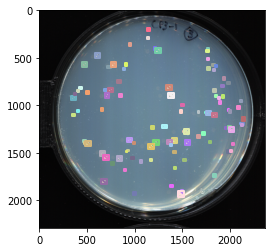

In [65]:
visualize_coco = COCO(os.path.join(ann_path, 'test.json'))

catIds = visualize_coco.getCatIds(catNms=['g', 'p']) #grande and petite categories
imgIds = visualize_coco.getImgIds(catIds=catIds )

img = visualize_coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
annIds = visualize_coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

I = Image.open(img['file_name']).convert('RGB')
#plt.axis('off')
plt.imshow(I)
anns = visualize_coco.loadAnns(annIds)
visualize_coco.showAnns(anns,True)

plt.show(I)